In [1]:
import py21cmcast as p21c
import numpy as np 

from astropy import units

import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

%load_ext autoreload
%autoreload 2

/home/users/g/f/gfacchin/exo21cmFAST_release/exo21cmFAST/src/py21cmfast/_cfg.py:57: UserWarning: Your configuration file is out of date. Updating...
  warnings.warn(
/home/users/g/f/gfacchin/exo21cmFAST_release/exo21cmFAST/src/py21cmfast/_cfg.py:41: UserWarning: Your configuration file is out of date. Updating...
  warnings.warn("Your configuration file is out of date. Updating...")


## I. Create the configuration files for varying parameters

See the examples of master configuration files in the config folder. Running **init\_fisher\_from\_fiducial** will create a folder (named after the run name set in the master configuration file) and sub configuration files inside (which correspond to the variation of each parameter). Once they are created each can by run with the script [**run\_fisher.py**](https://github.com/gaetanfacchinetti/21cmCAST/blob/main/scripts/exec/run_fisher.py). Note that the script takes at least one argument (the name of the sub configuration files to run) and three optional: the number of threads, the number of the first seed, and the number of times the same script should be run with increasing seeds. The latter is only usefull to run several fiducial cases in order to determine what the 'average Universe' looks like. In practice, for a Fisher forecast one should fix the seed to a single value for all the runs. 

In [7]:
configuration_file = "../config/constraint_bkr_minihalos.config"
p21c.init_runs_from_fiducial(configuration_file, clean_existing_dir=False)

Parameter F_STAR10 varied by 3.0 percent of the fiducial
Parameter F_STAR7_MINI varied by 3.0 percent of the fiducial
Parameter ALPHA_STAR varied by 3.0 percent of the fiducial
Parameter ALPHA_STAR_MINI varied by 3.0 percent of the fiducial
Parameter t_STAR varied by 3.0 percent of the fiducial
Parameter F_ESC10 varied by 3.0 percent of the fiducial
Parameter F_ESC7_MINI varied by 3.0 percent of the fiducial
Parameter ALPHA_ESC varied by 3.0 percent of the fiducial
Parameter L_X varied by 0.1 percent of the fiducial
Parameter L_X_MINI varied by 0.1 percent of the fiducial
Parameter NU_X_THRESH varied by 3.0 percent of the fiducial


## II. Define the grid of modes and redshifts

Let us call the function **define\_grid\_modes\_redshits()**. It returns the bin edges for a fixed grid of modes and redshifts.

- The redshift bins are computed from the frequency according to the formula
\begin{equation}
z_n \equiv \frac{f_{21}}{\frac{f_{21}}{1+z_0} - n B} -1
\end{equation}
where $B$ is the bandwidth and $f_{21}$ is the 21cm frequency.

- The mode bins are computed from the bandwidth according to the formula
\begin{equation}
k_n \equiv {\rm max} \left\{k_{\rm min},  \delta k \right\} + n \delta k \quad {\rm with} \quad \delta k \equiv 2\pi \frac{f_{21}}{B} \frac{H(z_0)}{c(1+z_0)^2}
\end{equation}
This definition corresponds to the bins set by **21cmSense**. Note that the choice of redshift $z_0$ fixes the step of the mode bins.

In [2]:
z_bins, k_bins = p21c.define_grid_modes_redshifts(6., 8 * units.MHz, z_max = 22, k_min = 0.1 / units.Mpc, k_max = 1 / units.Mpc)
print("The redshift bin edges are:", z_bins)
print("The mode bin edges are:", k_bins)

The redshift bin edges are: [ 6.          6.28730456  6.5992025   6.93899281  7.31059216  7.71868653
  8.16892985  8.66820756  9.22499121  9.84982306 10.55599    11.36047883
 12.28536057 13.35984643 14.62342929 16.13084378 17.96020444 20.22698157]
The mode bin edges are: [0.1        0.15329426 0.20658851 0.25988277 0.31317703 0.36647129
 0.41976554 0.4730598  0.52635406 0.57964831 0.63294257 0.68623683
 0.73953109 0.79282534 0.8461196  0.89941386 0.95270811] 1 / Mpc


## III. Define the fiducial model and get its power spectrum

A **Fiducial** object can be defined by specifying the path where the lightcones are saved (depends on what was set on the config file) as well as  the redshifts and modes bin edges. Note that we must set by hand whether the mode bins are linearly of logarithmically spaced with the option **logk**  that is by default **False** as the output mode bin deges returned by **define\_grid\_modes\_redshits()** are linearly spaced. Further options can be specified, such as an **observation**  and a fraction of modeling error **frac\_mod** (see below).

In [3]:
fiducial = p21c.Fiducial("../runs/CONSTRAINT_BKR_MINIHALOS", z_bins, k_bins, False, load = True)

Once the fiducial model is defined, we can check some of its properties:
- by plotting the neutral hydrogen fraction 'xH_box' (provided they have been asked as output of the lightcone) and computing the optical depth to reionization
- by computing the reduced $\chi^2$ value from the UV luminosity data

In [ ]:
fiducial.plot_xH_box()
fiducial.plot_global_signal()

chi2 = fiducial.chi2_UV_luminosity_functions(plot = True)

print('The optical depth to reionization is:', fiducial.tau_ion)
print('The reduced chi^2 from UV luminosity data is:', chi2)

## IV. Evaluate experimental noise

The experimental noise is derived using **21cmSense**. To that end one simply has to fix the 'observation' attribute of the fiducial object. The only valid input for now is 'HERA' but other can be added straightforwardly.

In [4]:
%%capture 
## Remove the long 21cmSense output

fiducial.observation = 'HERA'
fiducial.plot_power_spectrum()

## V. Define the Parameter objects

(This part is the longest and can take minutes or hours depending on the box resolution). Here all power spectra and associated derivatives are pre-computed and stored as atrribute of the **Parameter** object. With the load and save options of the **Parameter** class, if this part of code has been executed once, then all the objects can be reloaded in an instant (since every pre-computed quantity is stored in .npz and .pkl files).

In [6]:
## Classical sets of parameters
#parameter_names = ['F_STAR10', 'ALPHA_STAR', 'F_ESC10', 'ALPHA_ESC',  'M_TURN', 't_STAR', 'L_X', 'NU_X_THRESH']
parameter_names = ['F_STAR10', 'F_STAR7_MINI', 'ALPHA_STAR', 'ALPHA_STAR_MINI',  't_STAR', 
                   'F_ESC10', 'F_ESC7_MINI', 'ALPHA_ESC', 'L_X', 'L_X_MINI', 'NU_X_THRESH']
#parameter_names = ['F_STAR10', 'ALPHA_STAR', 'F_ESC10', 'ALPHA_ESC', 'F_STAR7_MINI', 'ALPHA_STAR_MINI',
#                  'F_ESC7_MINI',  'A_LW', 'L_X', 'NU_X_THRESH']

params = [None] * len(parameter_names)

for iname, name in enumerate(parameter_names) :  
    params[iname] = p21c.Parameter(fiducial=fiducial, name=name, verbose = False, plot = False, load=True)
    #params[iname].plot_power_spectra(color=['b', 'k', 'r'])

Treating parameter F_STAR10
Treating parameter F_STAR7_MINI
Treating parameter ALPHA_STAR
Treating parameter ALPHA_STAR_MINI
Treating parameter t_STAR
Treating parameter F_ESC10
Treating parameter F_ESC7_MINI
Treating parameter ALPHA_ESC
Treating parameter L_X
Treating parameter L_X_MINI
Treating parameter NU_X_THRESH


In [17]:
extra_names  = ['m6.5', 'm7.0', 'm7.5', 'm8.0', 'm8.5', 'm9.0', 'm9.5', 'm10.0', 'm10.5', 'm11.0', 'm11.5', 'm12.0']
#extra_names  = ['m2.0', 'm3.0', 'm4.0', 'm5.0', 'm6.0', 'm7.0', 'm8.0', 'm9.0', 'm10.0', 'm11.0', 'm12.0']
#extra_names  = ['m2.0', 'm3.0', 'm4.0, 'm8.0', 'm8.5', 'm9.0', 'm9.5', 'm10.0', 'm10.5', 'm11.0', 'm11.5', 'm12.0']
#values        = [1e-30, 1e-30, 1e-27, 1e-27, 1e-27, 1e-27, 1e-27, 1e-27, 1e-27, 1e-27, 1e-27]
values        = [5e-29, 5e-29, 5e-29, 5e-29, 5e-29, 5e-29, 5e-29, 5e-29, 5e-29, 1e-27, 1e-27, 1e-27]
extra_params = [None] * len(extra_names)

for iname, extra_name in enumerate(extra_names) :  
    extra_params[iname] = p21c.Parameter(fiducial=fiducial, name='DM_DECAY_RATE', verbose = False, plot=False, load=True, add_name = extra_name, values=values[iname])
    #extra_params[iname].plot_power_spectra(color=['b', 'k', 'r'])

Treating parameter DM_DECAY_RATE (m6.5)
Treating parameter DM_DECAY_RATE (m7.0)
Treating parameter DM_DECAY_RATE (m7.5)
Treating parameter DM_DECAY_RATE (m8.0)
Treating parameter DM_DECAY_RATE (m8.5)
Treating parameter DM_DECAY_RATE (m9.0)
Treating parameter DM_DECAY_RATE (m9.5)
Treating parameter DM_DECAY_RATE (m10.0)
Treating parameter DM_DECAY_RATE (m10.5)
Treating parameter DM_DECAY_RATE (m11.0)
Treating parameter DM_DECAY_RATE (m11.5)
Treating parameter DM_DECAY_RATE (m12.0)


## VI. Evaluate the Fisher matrix and its inverse

From the list of parameters objects defined above one can directly compute the Fisher matrix with the **evaluate\_fisher\_matrix()** function. One can add a modeling noise to the power spectrum with the attribute **frac\_noise** of the fiducial (as a percentage of the fiducial value). The triangle plot figure can be produced with the function **make\_triangle\_plot()** and plotted. Finally, the matrices can be displayed nicely with the **display\_matrix()** function.

In [21]:
fiducial.frac_noise = 0.2

sigma_tau = np.zeros(len(extra_names))



for iname, extra_name in enumerate(extra_names) : 
    fisher_matrix     = p21c.evaluate_fisher_matrix([*params, extra_params[iname]])
    covariance_matrix = np.linalg.inv(fisher_matrix['matrix'])
    #fig = p21c.make_triangle_plot(covariance_matrix, fisher_matrix['name'], fiducial.astro_params)
    #fig.savefig(fiducial.dir_path + '/triangle_plot_' + extra_name + '.pdf')
    sigma_tau[iname] = 1/(2.*np.sqrt(covariance_matrix[-1][-1]))

print('----------')
np.array(sigma_tau)

2
2
2
2
2
2
2
2
2
2
2
2
----------


array([1.92072342e+26, 7.19753887e+25, 7.87241108e+26, 1.48847148e+27,
       1.31945097e+27, 5.99765748e+26, 2.17538662e+26, 7.99678429e+25,
       3.12642986e+25, 1.28173880e+25, 6.13995762e+24, 2.65379408e+24])

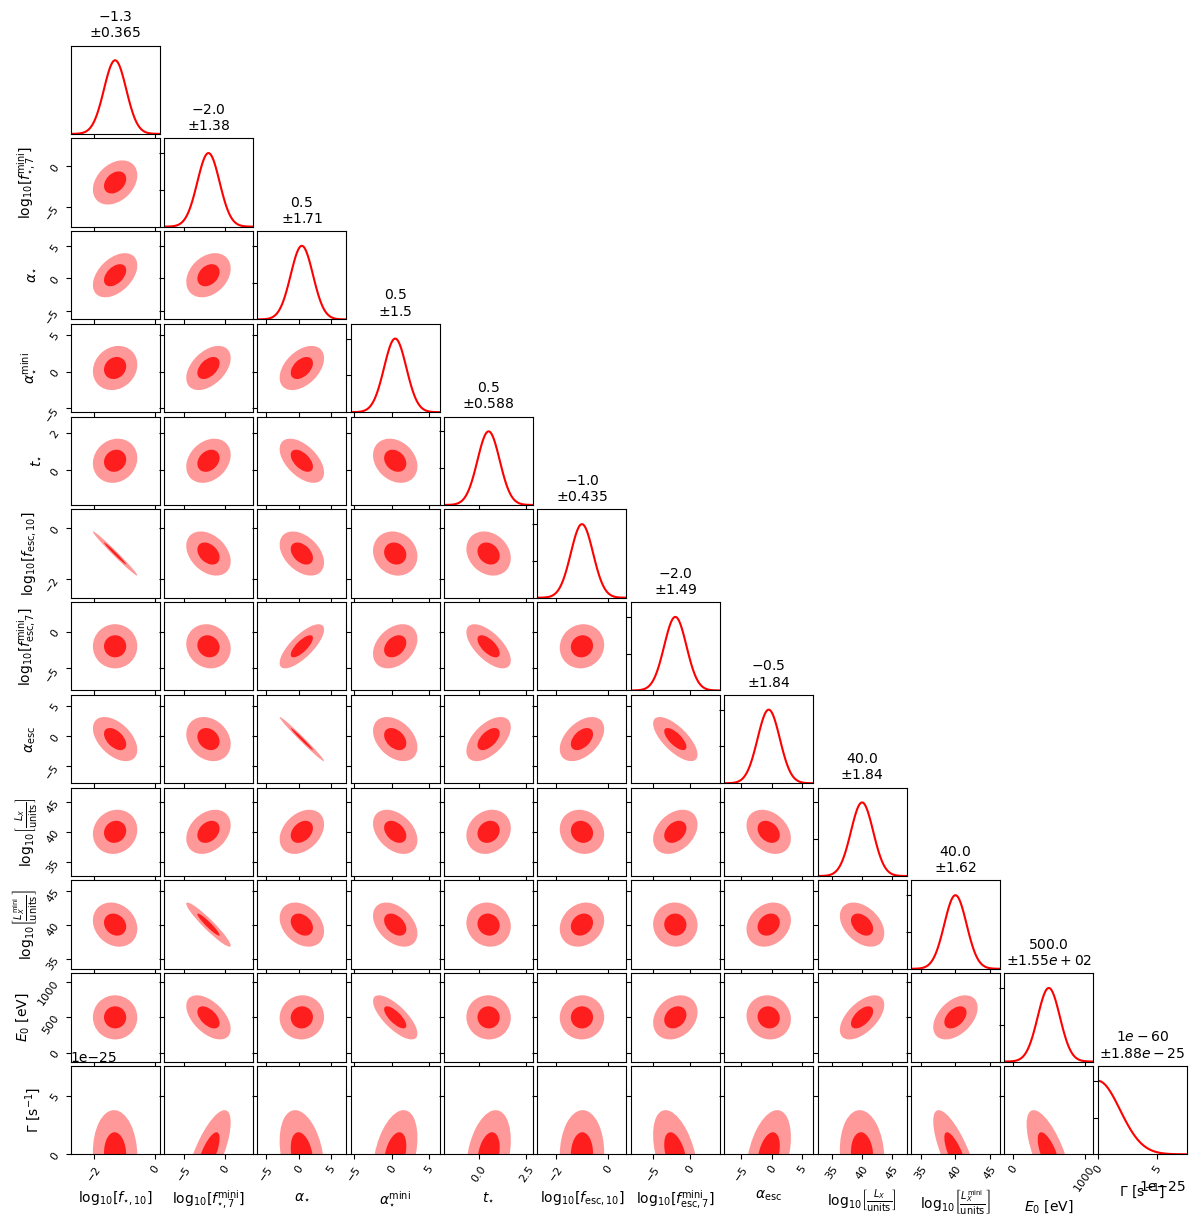

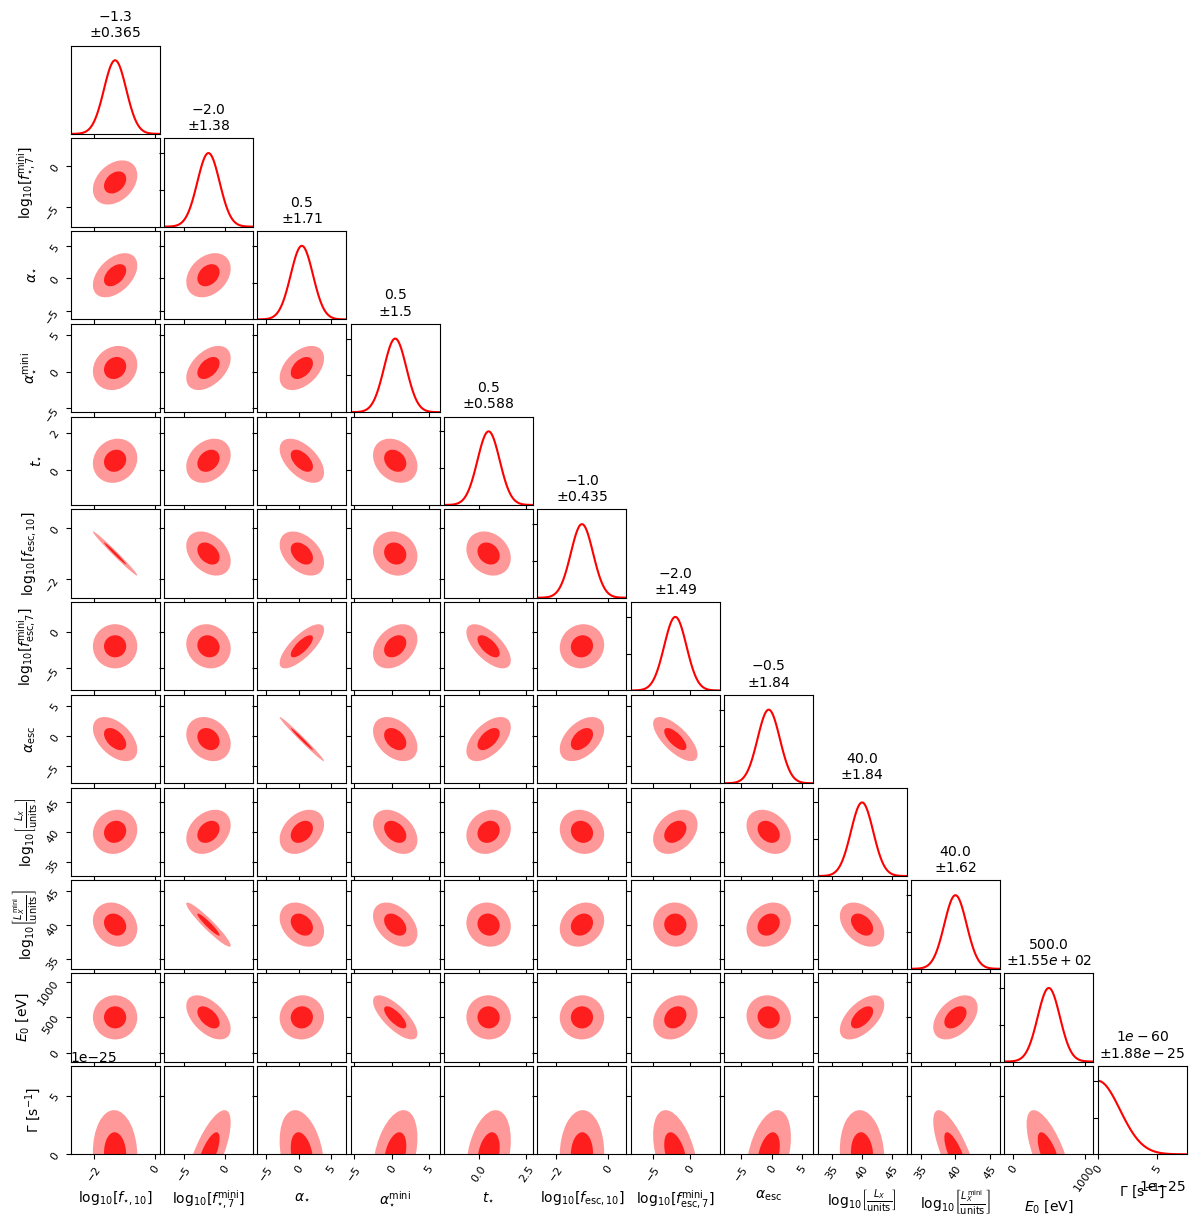

In [34]:
%matplotlib inline
p21c.make_triangle_plot(covariance_matrix, fisher_matrix['name'], fiducial.astro_params, color=['r'])

In [23]:
#parameter_names = ['F_STAR10', 'F_STAR7_MINI', 'ALPHA_STAR', 'ALPHA_STAR_MINI', 
#                   'F_ESC10', 'F_ESC7_MINI', 'ALPHA_ESC', 'L_X', 'NU_X_THRESH']

parameter_names = ['F_STAR10', 'ALPHA_STAR', 'F_ESC10', 'ALPHA_ESC', 'F_STAR7_MINI', 'ALPHA_STAR_MINI',
                  'F_ESC7_MINI',  'A_LW', 'L_X', 'NU_X_THRESH']

params = [None] * len(parameter_names)

for iname, name in enumerate(parameter_names) :  
    params[iname] = p21c.Parameter(fiducial=fiducial, name=name, verbose = False, plot = False, load=True)

fiducial.frac_noise = 0.2

fisher_matrix     = p21c.evaluate_fisher_matrix(params)
covariance_matrix = np.linalg.inv(fisher_matrix['matrix'])
fig = p21c.make_triangle_plot(covariance_matrix, fisher_matrix['name'], fiducial.astro_params)
fig.savefig(fiducial.dir_path + '/triangle_plot.pdf')

Treating parameter F_STAR10
Treating parameter ALPHA_STAR
Treating parameter F_ESC10
Treating parameter ALPHA_ESC
Treating parameter F_STAR7_MINI
Treating parameter ALPHA_STAR_MINI
Treating parameter F_ESC7_MINI
Treating parameter A_LW
Treating parameter L_X
Treating parameter NU_X_THRESH
